In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix, classification_report
)
from time import time
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
dosya_adi = 'NYC_Crash_Model_Final.csv'

try:
    df = pd.read_csv(dosya_adi)
    print(f"Veri yüklendi! Boyut: {df.shape}")
except FileNotFoundError:
    print("Dosya bulunamadı.")


Veri yüklendi! Boyut: (1911073, 43)


In [3]:
print("--- Sütunlar Filtreleniyor ---")

hedef_sutunlar = ['LATITUDE', 'LONGITUDE', 'HOUR', 'IS_MULTI_VEHICLE']
extra_cols = [col for col in df.columns if 'VEHICLE_' in col or 'FACTOR_' in col]
hedef_sutunlar.extend(extra_cols)

if 'SEVERITY' in df.columns:
    hedef_sutunlar.append('SEVERITY')

df_filtered = df[hedef_sutunlar].copy()


if 'SEVERITY' in df_filtered.columns:
    df_filtered['SEVERITY'] = df_filtered['SEVERITY'].replace(2, 1)

print(f"Kullanılan Sütun Sayısı: {len(df_filtered.columns)}")

y = df_filtered['SEVERITY']
X = df_filtered.drop(columns=['SEVERITY']).astype('float32')

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

--- Sütunlar Filtreleniyor ---
Kullanılan Sütun Sayısı: 31


In [4]:
def evaluate_and_plot(model, X_test, y_test, name="Model"):
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None
    
    acc = accuracy_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob) if y_prob is not None else None
    
    print("=======================================")
    print(f"{name} SONUÇ RAPORU")
    print("=======================================")
    print("Accuracy :", acc)
    print("Recall   :", rec)
    print("F1 Score :", f1)
    print("ROC-AUC  :", auc)
    
    print("--- Confusion Matrix ---")
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
    plt.title(f"{name} - Confusion Matrix")
    plt.show()
    
    print("--- Classification Report ---")
    print(classification_report(y_test, y_pred))
    
    if y_prob is not None:
        from sklearn.metrics import RocCurveDisplay
        RocCurveDisplay.from_predictions(y_test, y_prob)
        plt.title(f"{name} ROC Curve")
        plt.show()


In [5]:
log_reg = LogisticRegression(
    random_state=42, max_iter=2000, class_weight="balanced", solver="liblinear"
)

log_params = {
    "C": [1, 10, 100, 500]
}

clf_lr = RandomizedSearchCV(
    estimator=log_reg,
    param_distributions=log_params,
    n_iter=3,
    cv=2,
    scoring="f1",
    n_jobs=1,
    random_state=42
)

start = time()
clf_lr.fit(X_train, y_train)
print("En iyi parametreler:", clf_lr.best_params_)
print("Eğitim süresi:", round(time() - start, 2), "sn")

best_lr = clf_lr.best_estimator_


En iyi parametreler: {'C': 500}
Eğitim süresi: 153.51 sn


Logistic Regression SONUÇ RAPORU
Accuracy : 0.713331501903379
Recall   : 0.4516616477242064
F1 Score : 0.4330516762305897
ROC-AUC  : 0.6717272163651077
--- Confusion Matrix ---


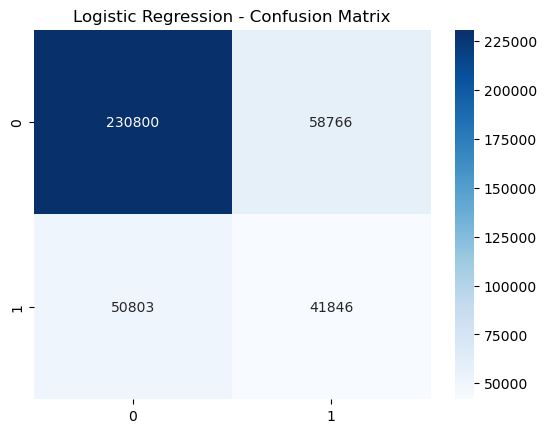

--- Classification Report ---
              precision    recall  f1-score   support

           0       0.82      0.80      0.81    289566
           1       0.42      0.45      0.43     92649

    accuracy                           0.71    382215
   macro avg       0.62      0.62      0.62    382215
weighted avg       0.72      0.71      0.72    382215



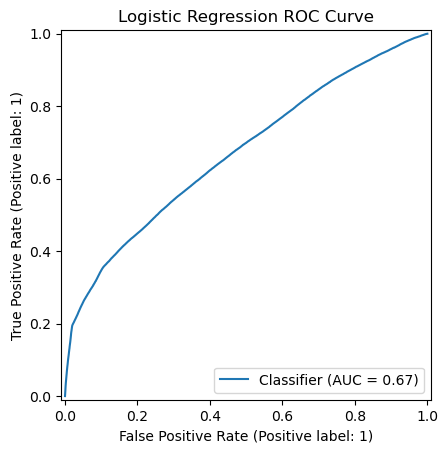

In [6]:
evaluate_and_plot(best_lr, X_test, y_test, "Logistic Regression")

In [7]:
tree = DecisionTreeClassifier(random_state=42, class_weight='balanced')

tree_params = {
    "max_depth": [20, 30, 50, None],
    "min_samples_leaf": [5, 10, 20],
    "min_samples_split": [20, 50]
}

clf_tree = RandomizedSearchCV(
    estimator=tree,
    param_distributions=tree_params,
    n_iter=3,
    cv=2,
    scoring="f1",
    n_jobs=1,
    random_state=42
)

start = time()
clf_tree.fit(X_train, y_train)
print("En iyi parametreler:", clf_tree.best_params_)
print("Eğitim süresi:", round(time() - start, 2), "sn")

best_tree = clf_tree.best_estimator_


En iyi parametreler: {'min_samples_split': 20, 'min_samples_leaf': 5, 'max_depth': 20}
Eğitim süresi: 48.65 sn


Decision Tree SONUÇ RAPORU
Accuracy : 0.6731394633910234
Recall   : 0.566741141296722
F1 Score : 0.45669654311645724
ROC-AUC  : 0.6911476051758126
--- Confusion Matrix ---


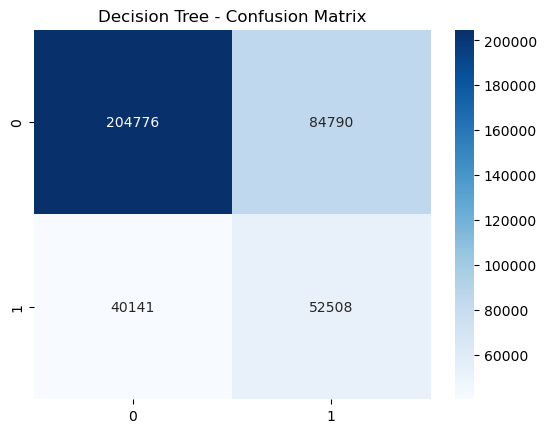

--- Classification Report ---
              precision    recall  f1-score   support

           0       0.84      0.71      0.77    289566
           1       0.38      0.57      0.46     92649

    accuracy                           0.67    382215
   macro avg       0.61      0.64      0.61    382215
weighted avg       0.73      0.67      0.69    382215



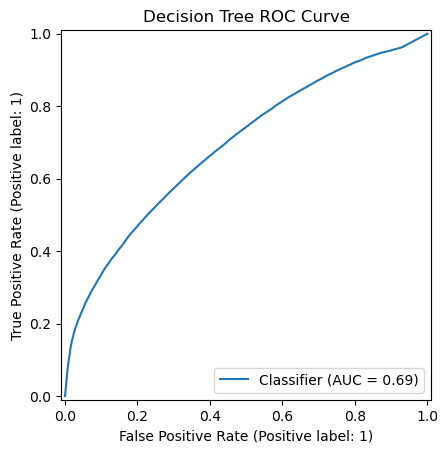

In [8]:
evaluate_and_plot(best_tree, X_test, y_test, "Decision Tree")


In [9]:
nb = GaussianNB()

nb_params = {
    "var_smoothing": [1e-9, 1e-8]
}

clf_nb = RandomizedSearchCV(
    estimator=nb,
    param_distributions=nb_params,
    n_iter=2,
    cv=2,
    scoring="f1",
    n_jobs=1,
    random_state=42
)

start = time()
clf_nb.fit(X_train, y_train)
print("En iyi parametreler:", clf_nb.best_params_)
print("Eğitim süresi:", round(time() - start, 2), "sn")

best_nb = clf_nb.best_estimator_


En iyi parametreler: {'var_smoothing': 1e-08}
Eğitim süresi: 3.78 sn


Gaussian Naive Bayes SONUÇ RAPORU
Accuracy : 0.4922648247713983
Recall   : 0.7213245690725211
F1 Score : 0.40784318511918566
ROC-AUC  : 0.6409986416954844
--- Confusion Matrix ---


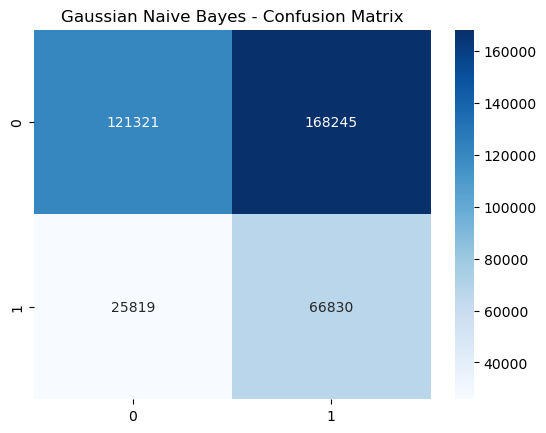

--- Classification Report ---
              precision    recall  f1-score   support

           0       0.82      0.42      0.56    289566
           1       0.28      0.72      0.41     92649

    accuracy                           0.49    382215
   macro avg       0.55      0.57      0.48    382215
weighted avg       0.69      0.49      0.52    382215



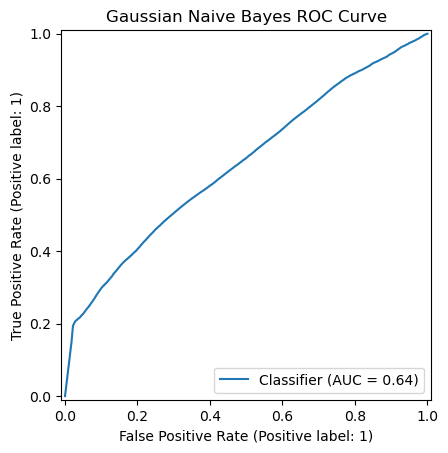

In [10]:
evaluate_and_plot(best_nb, X_test, y_test, "Gaussian Naive Bayes")


In [11]:
comparison = pd.DataFrame([
    ["Logistic Regression",
     accuracy_score(y_test, best_lr.predict(X_test)),
     recall_score(y_test, best_lr.predict(X_test)),
     f1_score(y_test, best_lr.predict(X_test)),
     roc_auc_score(y_test, best_lr.predict_proba(X_test)[:, 1])
    ],
    ["Decision Tree",
     accuracy_score(y_test, best_tree.predict(X_test)),
     recall_score(y_test, best_tree.predict(X_test)),
     f1_score(y_test, best_tree.predict(X_test)),
     roc_auc_score(y_test, best_tree.predict_proba(X_test)[:, 1])
    ],
    ["Gaussian NB",
     accuracy_score(y_test, best_nb.predict(X_test)),
     recall_score(y_test, best_nb.predict(X_test)),
     f1_score(y_test, best_nb.predict(X_test)),
     roc_auc_score(y_test, best_nb.predict_proba(X_test)[:, 1])
    ]
], columns=["Model", "Accuracy", "Recall", "F1 Score", "ROC-AUC"])

comparison


,Model,Accuracy,Recall,F1 Score,ROC-AUC
0,Logistic Regression,0.713332,0.451662,0.433052,0.671727
1,Decision Tree,0.673139,0.566741,0.456697,0.691148
2,Gaussian NB,0.492265,0.721325,0.407843,0.640999
